# Calculation of empirical p-values and FDRs for LFC values

- Redo counts normalization
    - RPM (reads per million) with pseudo-count of 1
- Calculate LFC for each replicate relative to median “input” gRNA RPM 
- Generate empirical null distribution by combining all replicates of non- and safe-targeting gRNAs in each condition


    - Bootstrap to generate a sufficiently large null distribution



- Calculate empirical p-value (low and high) based on null distribution
    - P(high) = (S+1)/(N+1), where s = # of null values GREATER than gRNA of interest
    - P(low) = same, but s = # of null values LESS than gRNA of interest
- Combine p-values using Fisher’s method
- Perform FDR correction using Benjamini-Hochberg method

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import warnings
import os
import functools
import upsetplot
from adjustText import adjust_text
import matplotlib.patheffects as PathEffects

warnings.filterwarnings('ignore')
plt.rc('font', family='Helvetica')

In [96]:
#loading in barcode counts

ABE_counts = pd.read_csv('mageck/ABE_bc_counts.txt', sep='\t')
CBE_counts = pd.read_csv('mageck/CBE_bc_counts.txt', sep='\t')


#and normalize to generate RPM values
samples_CBE = list(CBE_counts.columns[2:])

CBE_RPM = CBE_counts.copy()

#add pseudocount of 1 to each sample
#and normalize + calculate RPM
pseudocount = 1
for k in samples_CBE:
    col = np.asarray(CBE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    CBE_RPM[k] = rpm


#and do the same for ABE
ABE_RPM = ABE_counts.copy()
samples_ABE = list(ABE_counts.columns[2:])

pseudocount = 1
for k in samples_ABE:
    col = np.asarray(ABE_counts[k]) + pseudocount
    sum_col = np.sum(col)
    rpm = 1e6*(col/sum_col)
    ABE_RPM[k] = rpm

# 1. Construction of bootstrapped null distributions

Procedure: 
- Determine LFC values of non- and safe-targeting gRNAs in each sample
- Use these to construct an empirical null distribution
- Bootstrap sample to construct a distribution of sufficient size


Quality Control steps:
- Ensure similarity between distributions among different samples from same tissue and editor

# 1a. Generating LFC tables

- Simple sequencing depth normalization with RPM(count+1)
- Determine LFC relative to "input" sequences
- Add sensor editing information from day 5

In [104]:
#instatiate dictionaries containing information about all of the samples and their corresponding replicates
CBE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4','spleen5','spleen6','spleen7','spleen8','spleen9'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5','bonemarrow6','bonemarrow7','bonemarrow8','bonemarrow9','bonemarrow10'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5','meninges6','meninges7','meninges8','meninges9','meninges10',],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],
 'plasmid_lib':['plasmidlib']}

ABE_samp_dict = {'spleen':['spleen1','spleen2','spleen3','spleen4'],
 'bonemarrow':['bonemarrow1','bonemarrow2','bonemarrow3','bonemarrow4','bonemarrow5'],
 'meninges':['meninges1','meninges2','meninges3','meninges4','meninges5'],
 'd5':['d5_rep1','d5_rep2','d5_rep3'],
 'd15':['d15_rep1','d15_rep2','d15_rep3'],
 'plasmid_lib':['plasmidlib']}

In [ ]:
#start with ABE

def LFC_table_generator(RPM_df, samp_dict, t0_comparison=['input_rep1', 'input_rep2', 'input_rep3']):
    """ 
    Function for generating LFC values
    RPM_df = dataframe containing RPM values (generated with pseudocount of +1)
    samp_dict = dictionary of samples and corresponding replicates
    t0_comparison = list containing base mean values for LFC calculation
    """


    dmso_median = np.median(RPM_df[t0_comparison], axis=1)

    df_holder = []
    for condition_of_interest in list(samp_dict.keys()):

        samp_of_interest = samp_dict[condition_of_interest]

        #calculate log2fc
        lfc_list = []
        for k in samp_of_interest:
            col = RPM_df[k]
            lfc = np.log2(col/dmso_median)

            lfc_list.append(lfc)

        lfc_table = pd.DataFrame(dict(zip(samp_of_interest, lfc_list)))
        lfc_table[f'LFC_avg_{condition_of_interest}'] = np.average(lfc_table[samp_of_interest], axis=1)
        lfc_table[f'LFC_median_{condition_of_interest}'] = np.median(lfc_table[samp_of_interest], axis=1)
        lfc_table['Input_median'] = dmso_median
        ids = RPM_df[['sgRNA', 'gene']]

        LFC_df = pd.concat((ids, lfc_table), axis=1)
        df_holder.append(LFC_df)

    #and combine different tissues into same table
    combined_LFC = pd.concat(df_holder, axis=1)
    combined_LFC= combined_LFC.loc[:,~combined_LFC.columns.duplicated()].copy()
    combined_LFC = combined_LFC.rename(columns = {'sgRNA':'gRNA_id', 'gene':'Gene'})

    return combined_LFC

In [ ]:
#generate LFC tables
ABE_LFC_table = LFC_table_generator(ABE_RPM, ABE_samp_dict, t0_comparison=['input_rep1', 'input_rep2', 'input_rep3'])
CBE_LFC_table = LFC_table_generator(CBE_RPM, CBE_samp_dict, t0_comparison=['input_rep1', 'input_rep2', 'input_rep3'])

In [127]:
#add in editing information
#USING THE D5 EDITING AS PROXY FOR ALL OTHER EDITING
d5_abe = pd.read_csv('ABE_editing/MLE/d5_ABE_MLE.csv')
##---USING UPDATED CBE EDITING THAT INCLUDES LEGACY GUIDES!!---
d5_cbe = pd.read_csv('CBE_editing_UPDATED/MLE/d5_CBE_MLE.csv')

#and then adding in editing information to the dataframe
abe_editing = d5_abe[['Guide_ID', 'Reads_aligned_all_amplicons', 'corr_perc',	'target_base_edit_perc', 'byproduct_INDEL_perc','byproduct_sub_perc']].rename(columns = {'Guide_ID':'gRNA_id', 'Reads_aligned_all_amplicons': 'sensor_reads'})
abe_editing = abe_editing[abe_editing['gRNA_id'].isin(ABE_counts['sgRNA'])]

cbe_editing = d5_cbe[['Guide_ID', 'Reads_aligned_all_amplicons', 'corr_perc',	'target_base_edit_perc', 'byproduct_INDEL_perc','byproduct_sub_perc']].rename(columns = {'Guide_ID':'gRNA_id', 'Reads_aligned_all_amplicons': 'sensor_reads'})
cbe_editing = cbe_editing[cbe_editing['gRNA_id'].isin(CBE_counts['sgRNA'])]


#also add in information about the edits of interest
library = pd.read_csv('MBESv2_CORRECTED.csv')[['gRNA_id', 'gene_name_m_corrected', 'gene_name_h', 'HGVSp_m', 'HGVSp_h', 'classification', 'classification_m']]
abe_editing = pd.merge(abe_editing, library, on='gRNA_id')
cbe_editing = pd.merge(cbe_editing, library, on='gRNA_id')


#and MERGE with LFC tables
ABE_LFC_table_w_editing = pd.merge(ABE_LFC_table, abe_editing, on='gRNA_id')
CBE_LFC_table_w_editing = pd.merge(CBE_LFC_table, cbe_editing, on='gRNA_id')

# 1b. Construction & visualization of null distributions

In [ ]:
#set np random seed for reproducibility
np.random.seed(0)

#select control gRNAs
null=['non_target', 'safe_target']

ABE_controls = ABE_LFC_table_w_editing[ABE_LFC_table_w_editing['Gene'].isin(null)].reset_index(drop=True)
CBE_controls = CBE_LFC_table_w_editing[CBE_LFC_table_w_editing['Gene'].isin(null)].reset_index(drop=True)


#generate null distributions with bootstrapping
conditions = ['d5', 'd15', 'spleen', 'bonemarrow', 'meninges']

ABE_bootstrapped_nulls = []
CBE_bootstrapped_nulls = []

for condition in conditions:
    samp_of_interest_CBE = CBE_samp_dict[condition]
    samp_of_interest_ABE = ABE_samp_dict[condition]

    #combine replicates and bootstrap sample
    nt_gRNA_values_CBE = CBE_controls[samp_of_interest_CBE].to_numpy().flatten()
    bootstrapped_dist_CBE = np.random.choice(nt_gRNA_values_CBE, size=10000, replace=True)

    nt_gRNA_values_ABE = ABE_controls[samp_of_interest_ABE].to_numpy().flatten()
    bootstrapped_dist_ABE = np.random.choice(nt_gRNA_values_ABE, size=10000, replace=True)

    CBE_bootstrapped_nulls.append(bootstrapped_dist_CBE)
    ABE_bootstrapped_nulls.append(bootstrapped_dist_ABE)


#create dictionaries for both
ABE_null_dict = dict(zip(conditions, ABE_bootstrapped_nulls))
CBE_null_dict = dict(zip(conditions, CBE_bootstrapped_nulls))

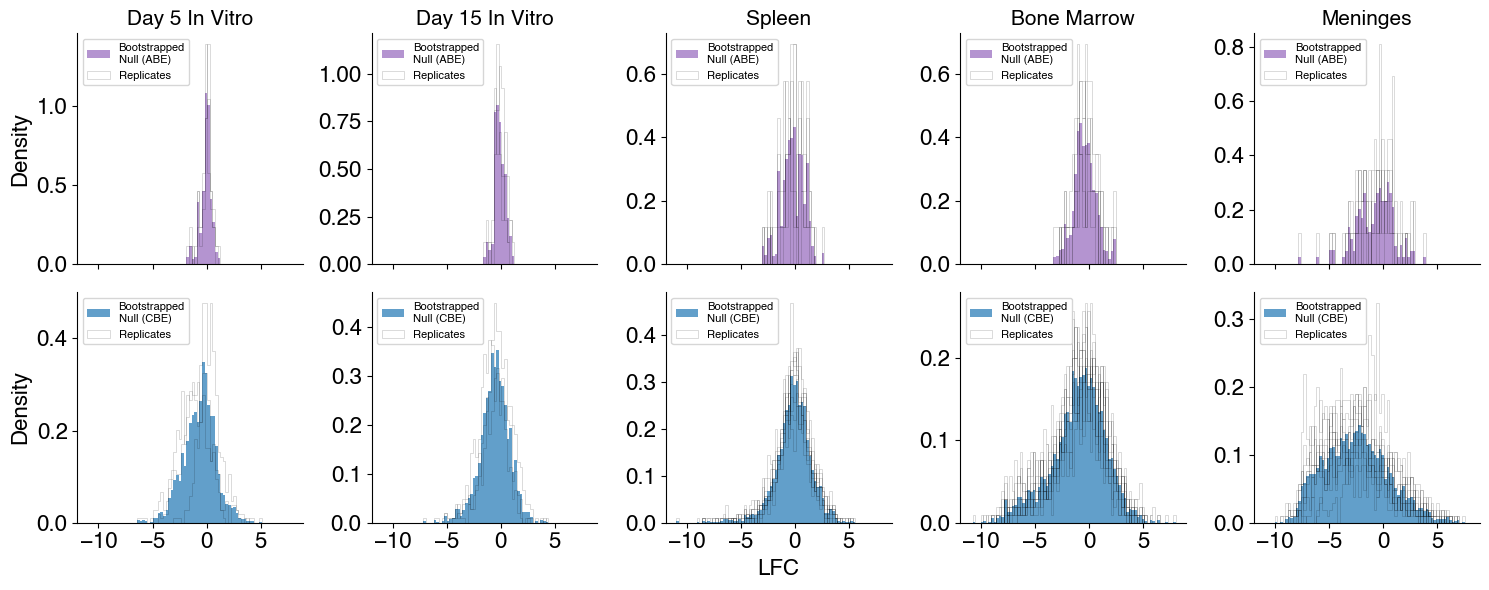

In [223]:
#visualizing the null distributions

fig, ax = plt.subplots(2,5, figsize=(15,6), sharex=True, sharey=False)

conditions = ['d5', 'd15', 'spleen', 'bonemarrow', 'meninges']
name_dict = dict(zip(conditions, ['Day 5 In Vitro', 'Day 15 In Vitro', 'Spleen', 'Bone Marrow', 'Meninges']))

for idx, condition in enumerate(conditions):
    bins = np.linspace(-11,8,80)

    ax[0][idx].hist(ABE_null_dict[condition], density=True, bins=bins, alpha=.7, color='tab:purple', label='Bootstrapped\nNull (ABE)')
    ax[1][idx].hist(CBE_null_dict[condition], density=True, bins=bins, alpha=.7, color='tab:blue', label='Bootstrapped\nNull (CBE)')

    ax[0][idx].set_title(name_dict[condition], fontsize=15)

    ax[0][idx].spines[['top', 'right']].set_visible(False)
    ax[1][idx].spines[['top', 'right']].set_visible(False)

    ax[0][idx].tick_params(axis='both', which='major', labelsize=16);
    ax[1][idx].tick_params(axis='both', which='major', labelsize=16);
    
    ax[0][0].set_ylabel('Density', fontsize=16)
    ax[1][0].set_ylabel('Density', fontsize=16)
    ax[1][2].set_xlabel('LFC', fontsize=16)

    ax[0][0].set_xticks([-10,-5,0,  5])

    #also plot the replicates
    samp_of_interest_CBE = CBE_samp_dict[condition]
    samp_of_interest_ABE = ABE_samp_dict[condition]

    for idx2, k in enumerate(samp_of_interest_ABE):
        if idx2==0:
            ax[0][idx].hist(ABE_controls[k], density=True, bins=bins, alpha=.2, linewidth=.5, color='black', histtype=u'step',label='Replicates')
        else:
            ax[0][idx].hist(ABE_controls[k], density=True, bins=bins, alpha=.2, linewidth=.5, color='black', histtype=u'step')
    
    for idx2, k in enumerate(samp_of_interest_CBE):
        if idx2==0:
            ax[1][idx].hist(CBE_controls[k], density=True, bins=bins, alpha=.2, linewidth=.5, color='black', histtype=u'step',label='Replicates')
        else:
            ax[1][idx].hist(CBE_controls[k], density=True, bins=bins, alpha=.2, linewidth=.5, color='black', histtype=u'step')
    
    ax[0][idx].legend(fontsize=8, loc='upper left')
    ax[1][idx].legend(fontsize=8, loc='upper left')

fig.tight_layout()

# 1c. Empirical p-value & FDR calculation

In [225]:
import numpy as np
from scipy.stats import combine_pvalues
from statsmodels.stats.multitest import multipletests

# Function to compute empirical p-values
def empirical_p_value(observed, null_distribution):
    S_high = sum(null_distribution >= observed)
    S_low = sum(null_distribution <= observed)
    N = len(null_distribution)

    # Compute two-sided p-value
    p_high = (S_high + 1) / (N + 1)
    p_low = (S_low + 1) / (N + 1)
    return p_high, p_low

def two_sided_FDR(condition_of_interest, samp_of_interest, LFC_df, null_dict):
    ''' 
    condition_of_interest = name of condition (e.g. "spleen")
    samp_of_interest = list of all replicates ["spleen1", "spleen2", "spleen3"]
    LFC_df = dataframe with LFC values
    null_dict = dictionary containing bootstrapped null distributions for each tissue & editor combination
    '''

    # Load the null distribution
    nt_gRNA_values = null_dict[condition_of_interest]

    # Targeting gRNAs (including NT for completeness)
    gRNA_values = np.asarray(LFC_df[samp_of_interest])

    # Compute p-values for each replicate separately (two-tailed)
    p_values_high = np.array([
        [empirical_p_value(rep, nt_gRNA_values)[0] for rep in gRNA] 
        for gRNA in gRNA_values
    ])
    p_values_low = np.array([
        [empirical_p_value(rep, nt_gRNA_values)[1] for rep in gRNA] 
        for gRNA in gRNA_values
    ])

    # Combine p-values across replicates using Fisher's method
    combined_p_values_high = np.array([
        combine_pvalues(p_vals, method='fisher')[1] for p_vals in p_values_high
    ])
    combined_p_values_low = np.array([
        combine_pvalues(p_vals, method='fisher')[1] for p_vals in p_values_low
    ])

    # Adjust for multiple testing (Benjamini-Hochberg FDR)
    adjusted_p_values_high = multipletests(combined_p_values_high, method='fdr_bh')[1]
    adjusted_p_values_low = multipletests(combined_p_values_low, method='fdr_bh')[1]

    # Store results in the dataframe
    LFC_df[f'p_high_unadjusted_{condition_of_interest}'] = combined_p_values_high
    LFC_df[f'p_low_unadjusted_{condition_of_interest}'] = combined_p_values_low
    LFC_df[f'FDR_high_{condition_of_interest}'] = adjusted_p_values_high
    LFC_df[f'FDR_low_{condition_of_interest}'] = adjusted_p_values_low

    #Combine low and high FDRs for ease of manipulation and plotting
    min_FDR = []
    for i, val in LFC_df.iterrows():
        FDR_low = val[f'FDR_low_{condition_of_interest}']
        FDR_high = val[f'FDR_high_{condition_of_interest}']
        min_FDR.append(min(FDR_low, FDR_high))

    LFC_df[f'FDR_{condition_of_interest}'] = min_FDR

    return LFC_df

In [226]:
#first perform computation for ABE samples

conditions = ['d5', 'd15', 'spleen', 'bonemarrow', 'meninges']

df_holder_ABE = []
for condition_of_interest in conditions:

    samp_of_interest = ABE_samp_dict[condition_of_interest]

    LFC_df = two_sided_FDR(condition_of_interest, samp_of_interest, ABE_LFC_table_w_editing, ABE_null_dict)

    df_holder_ABE.append(LFC_df)

combined_LFC_FDR_ABE = pd.concat(df_holder_ABE, axis=1)
combined_LFC_FDR_ABE = combined_LFC_FDR_ABE.loc[:,~combined_LFC_FDR_ABE.columns.duplicated()].copy()


In [ ]:
#then do the same for CBE samples
conditions = ['d5', 'd15', 'spleen', 'bonemarrow', 'meninges']

df_holder_CBE = []
for condition_of_interest in conditions:

    samp_of_interest = CBE_samp_dict[condition_of_interest]

    LFC_df = two_sided_FDR(condition_of_interest, samp_of_interest, CBE_LFC_table_w_editing, CBE_null_dict)

    df_holder_CBE.append(LFC_df)

combined_LFC_FDR_CBE = pd.concat(df_holder_CBE, axis=1)
combined_LFC_FDR_CBE = combined_LFC_FDR_CBE.loc[:,~combined_LFC_FDR_CBE.columns.duplicated()].copy()

In [243]:
#save dataframes
combined_LFC_FDR_ABE.to_csv('ABE_LFC_FDR_df.csv', index=False)
combined_LFC_FDR_CBE.to_csv('CBE_LFC_FDR_df.csv', index=False)

# 1d. Comparison with MAGeCK results

- Comparing the number & overlap of significant hit calls between MAGeCK (negative binomial parametric model), and our empirical, non-parametric approach
    - Our non-parametric approach is more conservative
    - Goal is to quantify the differences here and perform a sanity check

In [248]:
#load in MAGeCK results
fp = 'mageck/sgrna_summaries'

ABE_mageck_holder = []
CBE_mageck_holder = []

conditions = ['d5', 'd15', 'spleen', 'bonemarrow', 'meninges']

for condition in conditions:
    cbe = pd.read_csv(f'{fp}/CBE_{condition}_input.sgrna_summary.txt', sep='\t').rename(columns={'sgrna':'gRNA_id'})
    abe = pd.read_csv(f'{fp}/ABE_{condition}_input.sgrna_summary.txt', sep='\t').rename(columns={'sgrna':'gRNA_id'})

    CBE_mageck_holder.append(cbe)
    ABE_mageck_holder.append(abe)

ABE_mageck_dict = dict(zip(conditions, ABE_mageck_holder))
CBE_mageck_dict = dict(zip(conditions, CBE_mageck_holder))

In [312]:
#and perform comparison
FDR_cutoff = .1
min_input_counts = 5

above_threshold_gRNAs = list(combined_LFC_FDR_CBE[combined_LFC_FDR_CBE['Input_median']>=min_input_counts]['gRNA_id']) + list(combined_LFC_FDR_ABE[combined_LFC_FDR_ABE['Input_median']>=min_input_counts]['gRNA_id'])

mageck_sig_hits_CBE = []
mageck_sig_hits_ABE = []

empirical_sig_hits_CBE = []
empirical_sig_hits_ABE = []

conditions = ['d15', 'spleen', 'bonemarrow', 'meninges']

for tissue in conditions:
    mageck_CBE = CBE_mageck_dict[tissue]
    mageck_sig_CBE = mageck_CBE[(mageck_CBE['FDR']<FDR_cutoff) & mageck_CBE['gRNA_id'].isin(above_threshold_gRNAs)]

    mageck_ABE = ABE_mageck_dict[tissue]
    mageck_sig_ABE = mageck_ABE[(mageck_ABE['FDR']<FDR_cutoff) & mageck_ABE['gRNA_id'].isin(above_threshold_gRNAs)]

    empirical_CBE = combined_LFC_FDR_CBE[(combined_LFC_FDR_CBE[f'FDR_{tissue}']<FDR_cutoff) & (combined_LFC_FDR_CBE['gRNA_id'].isin(above_threshold_gRNAs))]
    empirical_ABE = combined_LFC_FDR_ABE[(combined_LFC_FDR_ABE[f'FDR_{tissue}']<FDR_cutoff) & (combined_LFC_FDR_ABE['gRNA_id'].isin(above_threshold_gRNAs))]

    mageck_sig_hits_CBE.append(list(mageck_sig_CBE['gRNA_id']))
    mageck_sig_hits_ABE.append(list(mageck_sig_ABE['gRNA_id']))

    empirical_sig_hits_CBE.append(list(empirical_CBE['gRNA_id']))
    empirical_sig_hits_ABE.append(list(empirical_ABE['gRNA_id']))

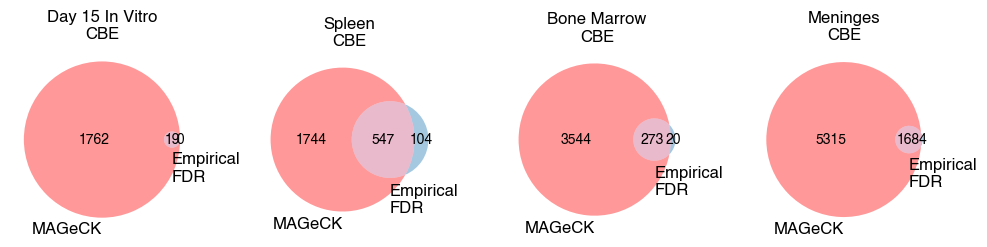

In [317]:
from matplotlib_venn import venn2

fig, axe =plt.subplots(1,4, figsize=(10,6))

for idx, tissue in enumerate(conditions):

    list1 = mageck_sig_hits_CBE[idx]
    list2 = empirical_sig_hits_CBE[idx]
    venn2([set(list1), set(list2)], set_labels=('MAGeCK', 'Empirical\nFDR'), set_colors=("red", "tab:blue"), ax=axe[idx])
    axe[idx].set_title(f'{name_dict[tissue]}\nCBE')

fig.tight_layout()

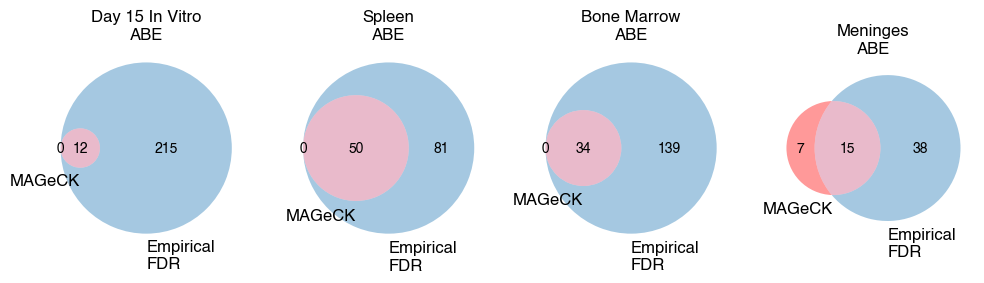

In [318]:
from matplotlib_venn import venn2

fig, axe =plt.subplots(1,4, figsize=(10,6))

for idx, tissue in enumerate(conditions):

    list1 = mageck_sig_hits_ABE[idx]
    list2 = empirical_sig_hits_ABE[idx]
    venn2([set(list1), set(list2)], set_labels=('MAGeCK', 'Empirical\nFDR'), set_colors=("red", "tab:blue"), ax=axe[idx])
    axe[idx].set_title(f'{name_dict[tissue]}\nABE')

fig.tight_layout()

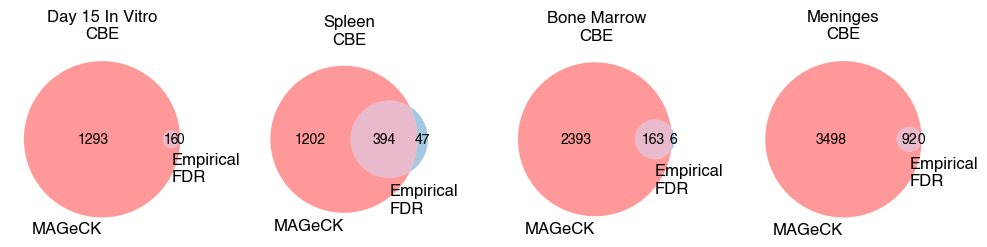

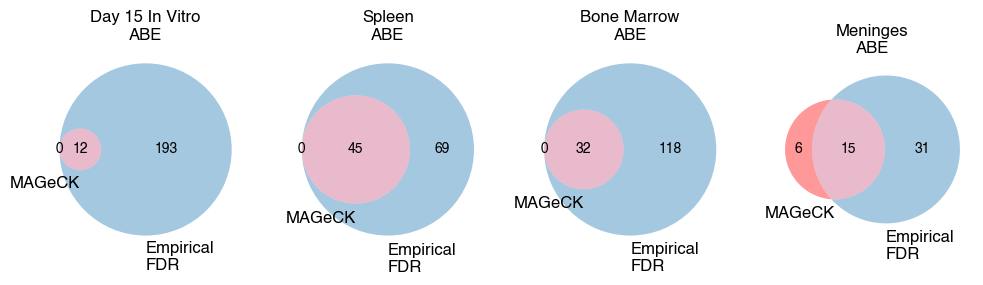

In [330]:
#further filter by editing rate
edit_cutoff = 20

high_edit_gRNAs = set(list(combined_LFC_FDR_CBE[combined_LFC_FDR_CBE['target_base_edit_perc']>=20]['gRNA_id']) + list(combined_LFC_FDR_ABE[combined_LFC_FDR_ABE['target_base_edit_perc']>=20]['gRNA_id']))

fig, axe =plt.subplots(1,4, figsize=(10,6))

for idx, tissue in enumerate(conditions):

    list1 = mageck_sig_hits_CBE[idx]
    list2 = empirical_sig_hits_CBE[idx]

    list11 = high_edit_gRNAs & set(list1)
    list22 = high_edit_gRNAs & set(list2)

    venn2([list11, list22], set_labels=('MAGeCK', 'Empirical\nFDR'), set_colors=("red", "tab:blue"), ax=axe[idx])
    axe[idx].set_title(f'{name_dict[tissue]}\nCBE')

fig.tight_layout()

fig, axe =plt.subplots(1,4, figsize=(10,6))

for idx, tissue in enumerate(conditions):

    list1 = mageck_sig_hits_ABE[idx]
    list2 = empirical_sig_hits_ABE[idx]

    list11 = high_edit_gRNAs & set(list1)
    list22 = high_edit_gRNAs & set(list2)

    venn2([list11, list22], set_labels=('MAGeCK', 'Empirical\nFDR'), set_colors=("red", "tab:blue"), ax=axe[idx])
    axe[idx].set_title(f'{name_dict[tissue]}\nABE')

fig.tight_layout()